In [29]:
#DATA
import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.
import pandas as pd
import numpy as np
#random forest for regressor
from sklearn.ensemble import RandomForestRegressor
#split features  and target
from sklearn.model_selection import train_test_split
#Pour regression au lieu de accuracy c'est mean_square_error
from sklearn.metrics import mean_squared_error
#Ne pas afficher le warning lors du fit par exemple
#Import for cross_validation
from sklearn.model_selection  import cross_val_score
#import random forest for regression
from sklearn.ensemble import RandomForestRegressor
#Validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
#Vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
# better visuals
sns.set()  
%matplotlib inline
from math import *
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


## IMPORT TRAIN - TEST - SUBMISSION

In [30]:
# Train File
X_train = pd.read_csv('../input/train.csv', index_col='id')
#Test File
X_test = pd.read_csv('../input/test.csv', index_col='id')
#Submission File
submission = pd.read_csv('../input/sample_submission.csv')

# 1     ------------------   EDA  -----------------------

In [31]:
X_train.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [32]:
X_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [33]:
X_test.head(2)

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
id,,,,,,,,
id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


In [34]:
X_test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


### ENCODING

In [5]:
# TRAIN
X_train.loc[X_train['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
X_train.loc[X_train['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1
# TEST
X_test.loc[X_test['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
X_test.loc[X_test['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1

## Vizualisation

In [26]:
##Add column distance
#R = 6367445 
#X_train["distance"] = R*acos(sin(X_train["pickup_latitude"])sin(X_train["dropoff_latitude"]) + cos(X_train["dropoff_latitude"])cos(X_train["pickup_longitude"] - X_train["dropoff_longitude"])))


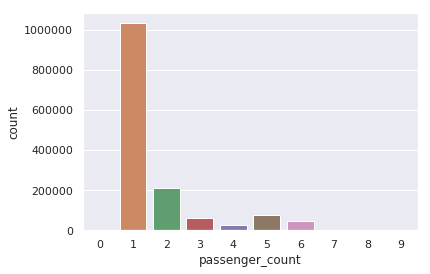

In [6]:
#plot the count of passenger_count
sns.countplot(x="passenger_count", data=X_train);

In [ ]:
#plot the count of trip_duration
#sns.countplot(x="trip_duration", data=X_train);

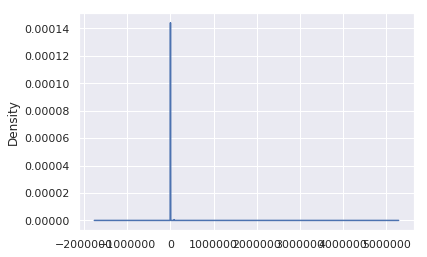

In [7]:
#X_train['trip_duration'].plot.kde()

## FILTER

In [ ]:
X_train = X_train[(X_train['trip_duration']  < 8000) & (X_train['passenger_count'] >= 1 )]

In [ ]:
X_train.describe()

In [ ]:
X_test.describe()

# 2  ------------------- FUNCTIONS---------------------------

## Function features and target

In [ ]:
## Fonction features et target
def split_dataset(df, features, target='trip_duration'):
    X = df[features]
    y = df[target]
    return X, y

## Function split date

In [ ]:
def date_split(df_train, df_test, date='pickup_datetime'):
    ##X_train
    cols=df_train[date]
    date_cols=pd.to_datetime(cols)
    df_train['year'] = date_cols.dt.year
    df_train['month'] = date_cols.dt.month
    df_train['day'] = date_cols.dt.day
    df_train['hour'] = date_cols.dt.hour
    df_train['minute'] = date_cols.dt.minute
    df_train['second'] = date_cols.dt.second
    #df_train = df_train.drop(['pickup_datetime'], axis=1)
    ##X_test
    cols2=df_test[date]
    date_cols2=pd.to_datetime(cols2)
    df_test['year'] = date_cols2.dt.year
    df_test['month'] = date_cols2.dt.month
    df_test['day'] = date_cols2.dt.day
    df_test['hour'] = date_cols2.dt.hour
    df_test['minute'] = date_cols2.dt.minute
    df_test['second'] = date_cols2.dt.second
    #df_test = df_test.drop(['pickup_datetime'], axis=1)
    return df_train, df_test

In [ ]:
#X_train['pickup_datetime']
#date_cols=pd.to_datetime(cols)
#X_train['year'] = date_cols.dt.year
#X_train.head(1)

# 3 ----------------------TREATMENT---------------------

In [ ]:
#Split  date for X_train et X_test
X_train, X_test = date_split(X_train, X_test)

## Function same columns  X_train and X_test

In [ ]:
# Get colums set test for set training
def Get_cols(df, features_test=X_test.columns):
    #get X_test columns in  X_train
    X_train_features = df[features_test]
    return  X_train_features

In [ ]:
#Same columns for X_test and X_train
X_trainGet_cols = Get_cols(X_test)
#Get only columns numbers
numbers = X_trainGet_cols.select_dtypes(np.number)
#Definition features and target in the file train
X_train_features, y_train_target = split_dataset(X_train, features=numbers.columns)
#X_test numbers
X_test = X_test.select_dtypes(np.number)

# 4----------------------Validation------------------------

In [ ]:
#rf = RandomForestRegressor()
#kf = KFold(n_splits=5, random_state=1)                                                                                      
#loses = cross_val_score(rf, X_train_features, y_train_target, cv=kf, scoring='neg_mean_squared_log_error')
# np.sqrt(-loses.mean())
#loses = [np.sqrt(-l) for l in loses]
# np.mean(loses)
#loses[:5]

In [ ]:
#Initialise Random Forest regressor
rf = RandomForestRegressor()
cv = ShuffleSplit(n_splits=3, test_size=0.05, train_size=0.1, random_state=42)
#Cross Validation
lossess = -cross_val_score(rf, X_train_features, y_train_target, cv=cv, scoring='neg_mean_squared_log_error')

# 5 -------------------FIT AND PREDICT----------------------

## FIT

In [ ]:
## FIT all the train set
rf = RandomForestRegressor()
rf.fit(X_train_features, y_train_target)

## PREDICTION

In [ ]:
##### Predict in the training
y_train_pred = rf.predict(X_train_features)

###### Predict in the test
y_test_pred = rf.predict(X_test)

y_test_pred.mean()

# 6 ------------------SUBMISSION-------------------------


In [35]:
#!rm submission.csv

rm: cannot remove 'submission.csv': No such file or directory


In [ ]:
submission["trip_duration"] = y_test_pred
#Convertir notre fichier en csv
submission.to_csv('submission.csv', index=False)